In [129]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import seaborn as sns

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [130]:
tak = pd.read_csv('Tayko.csv')

In [131]:
tak.columns

Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

In [132]:
tak.dtypes

sequence_number         int64
US                      int64
source_a                int64
source_c                int64
source_b                int64
source_d                int64
source_e                int64
source_m                int64
source_o                int64
source_h                int64
source_r                int64
source_s                int64
source_t                int64
source_u                int64
source_p                int64
source_x                int64
source_w                int64
Freq                    int64
last_update_days_ago    int64
1st_update_days_ago     int64
Web order               int64
Gender=male             int64
Address_is_res          int64
Purchase                int64
Spending                int64
dtype: object

In [133]:
tak.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0


In [134]:
tak.shape

(2000, 25)

In [135]:
tak['Spending'].value_counts()

0       999
130      39
161      31
128      22
98       19
       ... 
375       1
377       1
166       1
378       1
1500      1
Name: Spending, Length: 363, dtype: int64

In [136]:
pd.pivot_table(tak, values = ['Spending'], columns = ['US', 'Web order', 'Gender=male', 'Address_is_res'], aggfunc = {'Spending':[np.mean, np.std]})

                US  Web order  Gender=male  Address_is_res
Spending  mean  0   0          0            0                  88.794872
                                            1                  90.720000
                               1            0                  97.375000
                                            1                  34.350000
                    1          0            0                 145.033333
                                            1                 147.857143
                               1            0                  90.612903
                                            1                 122.166667
                1   0          0            0                  83.226866
                                            1                  89.200000
                               1            0                  82.638961
                                            1                  70.316667
                    1          0            0                 139

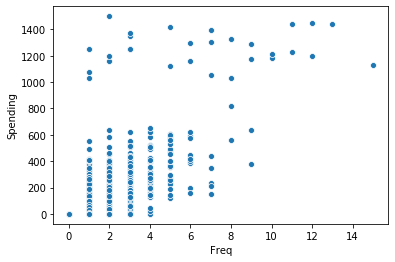

In [137]:
sns.scatterplot(x= 'Freq', y = 'Spending', data = tak)

From the chart above, there is no linear relationship between spending and frequency.

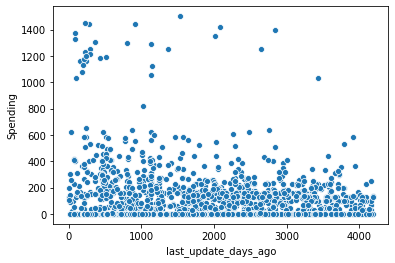

In [138]:
sns.scatterplot(y='Spending', x='last_update_days_ago', data = tak)

From the chart above, there is no linear relationship between last_update_days_ago and spending

In [139]:
predictors = ['US', 'Freq', 'last_update_days_ago', 'Web order', 'Gender=male', 'Address_is_res']         
outcome = 'Spending'         

In [140]:
#parition data
X = tak[predictors]
y = tak[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state=1)

tak_lm = LinearRegression()
tak_lm.fit(train_X, train_y)

#print coefficients
print('intercept', tak_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': tak_lm.coef_}))

intercept 10.176297414620265
              Predictor  coefficient
0                    US    -4.620293
1                  Freq    91.274450
2  last_update_days_ago    -0.010374
3             Web order    18.628731
4           Gender=male    -9.111366
5        Address_is_res   -75.815354


#predictive equation
Spending = -4.6*US + 91.3*Freq - 0.01*last_update_days_ago + 18.63*Web order - 9.11*Gender=male - 75.82*Address_is_res + 10.18

Based on this model, the type of purchaser that is likely to spend a large amount of money is the purchaser with a high number of transactions in the preceding year.

In [141]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose = True)

print(best_variables)

Variables: US, Freq, last_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=15028.53
Step: score=15026.76, remove US
Step: score=15026.38, remove Gender=male
Step: score=15026.38, remove None
['Freq', 'last_update_days_ago', 'Web order', 'Address_is_res']


Using backward elimination to reduce the number of predictors, the predictor to be dropped first from the model is US

In [142]:
valid_X[:1]

,US,Freq,last_update_days_ago,Web order,Gender=male,Address_is_res
674,1,2,1346,0,1,1


In [147]:
#Use predict() to make predictions on the first purchase in the validation set
tak_valid_pred = tak_lm.predict(valid_X[:1])

result = pd.DataFrame({'Predicted': tak_valid_pred, 'Actual': valid_y.iloc[674], 'Residual': valid_y.iloc[674] - tak_valid_pred})

print(result)

   Predicted  Actual    Residual
0  89.214915     267  177.785085


In [154]:
#Performance on the model on the whole validation set
tak_whole_valid_pred = tak_lm.predict(valid_X)
result = pd.DataFrame({'Predicted': tak_whole_valid_pred, 'Actual': valid_y, 'Residual': valid_y - tak_whole_valid_pred})
print(result.sample(20))

       Predicted  Actual    Residual
1672   86.761305       0  -86.761305
757  -112.577568       0  112.577568
986   205.664027     129  -76.664027
1459  -18.901743       0   18.901743
1631   53.384563     127   73.615437
899    92.163025       0  -92.163025
1848  815.673925    1176  360.326075
683    86.766675       0  -86.766675
774    76.176020     103   26.823980
11     99.062828       0  -99.062828
943   -22.889228       0   22.889228
1781   70.910578      10  -60.910578
1992  153.411502     133  -20.411502
135   368.542027     420   51.457973
1438   -5.671637       0    5.671637
718   -30.825262       0   30.825262
1250   64.644151       0  -64.644151
366    56.483276       0  -56.483276
1579  191.108854      98  -93.108854
1395  -15.378525       0   15.378525


0.775


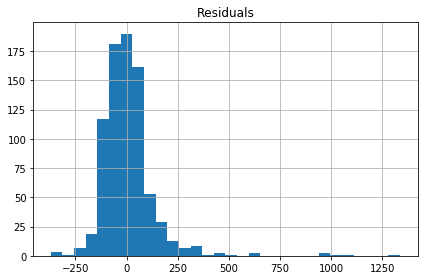

In [160]:
all_residuals = valid_y - tak_whole_valid_pred
#Determine the percentage of datapoints with residual in [-100, 100] = approx. 78%

print(len(all_residuals[(all_residuals > - 100) & (all_residuals < 100)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=30)
plt.tight_layout()
plt.show()

The model residuals does appear to follow a normal distribution.
When the residuls are more tightly organized toward the middle part of the distribution, it means that your spread of residuals is less. When your distribution is large, it is more widely spread from the middle of the distribution out to the tails; but with a tightly organized normal distribution, the spread of the residual is not wide and that is good because overall, the residuals are smaller and that means the lower the residuals or the erros in prediction, the better fit of a model.